In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime,timedelta
import sklearn.feature_selection
import lightgbm.sklearn

import pickle as pkl

/Users/davidsutton/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
 
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)
 
def test_gini():
    def fequ(a,b):
        return abs( a -b) < 1e-6
    def T(a, p, g, n):
        assert( fequ(gini(a,p), g) )
        assert( fequ(gini_normalized(a,p), n) )
    T([1, 2, 3], [10, 20, 30], 0.111111, 1)
    T([1, 2, 3], [30, 20, 10], -0.111111, -1)
    T([1, 2, 3], [0, 0, 0], -0.111111, -1)
    T([3, 2, 1], [0, 0, 0], 0.111111, 1)
    T([1, 2, 4, 3], [0, 0, 0, 0], -0.1, -0.8)
    T([2, 1, 4, 3], [0, 0, 2, 1], 0.125, 1)
    T([0, 20, 40, 0, 10], [40, 40, 10, 5, 5], 0, 0)
    T([40, 0, 20, 0, 10], [1000000, 40, 40, 5, 5], 0.171428,
       0.6)
    T([40, 20, 10, 0, 0], [40, 20, 10, 0, 0], 0.285714, 1)
    T([1, 1, 0, 1], [0.86, 0.26, 0.52, 0.32], -0.041666,
       -0.333333)

Read data

In [3]:
X_train= np.load(open('full_train_matrix_wp007.bin','rb'))
y_train= np.load(open('full_train_labels_wp007.bin','rb'))

IndexError: too many indices for array

In [ ]:
# X_test= np.load(open('../wp005/blind_test_matrix.bin','rb'))

In [ ]:
# test_ids= pd.read_csv('../data/test.csv',usecols=['id'])

In [3]:
def scoring_function(estimator,X_,y_):
    p= estimator.predict_proba(X_)
    return 2.*sklearn.metrics.roc_auc_score(y_,p[:,1])-1.

In [4]:
lgb_params = {}
lgb_params['learning_rate'] = 0.01
lgb_params['n_estimators'] = 1300
#lgb_params['max_depth'] = 10
lgb_params['max_bin'] = 10
lgb_params['subsample'] = 0.8
lgb_params['subsample_freq'] = 10
lgb_params['colsample_bytree'] = 0.8   
lgb_params['min_child_samples'] = 500
lgb_params['num_leaves']= 25
lgb_params['random_state']= 0
gbm = lightgbm.sklearn.LGBMClassifier(**lgb_params)

Run vanilla random forest

In [ ]:
tc= datetime.now()
selector = sklearn.feature_selection.RFECV(gbm, 
                                           step= 10, 
                                           cv= 3,
                                           scoring= scoring_function,
                                           verbose=1
                                          )
selector = selector.fit(X_train, y_train)
print 'RFE took: ',(datetime.now() - tc).total_seconds(),' seconds'

In [ ]:
pkl.dump(selector,open('selector_light.pkl','wb'))
plt.plot(range(len(selector.grid_scores_)), selector.grid_scores_)
plt.ylim([0.26,0.28])

In [12]:
selector.grid_scores_

array([ 0.        ,  0.2628249 ,  0.27290985,  0.27338119,  0.27295542,
        0.27279165,  0.27283163,  0.27260196,  0.27233182,  0.27307943])

In [17]:
sum(selector.ranking_ <= 2)

348

Narrow down further

In [5]:
light_selector= pkl.load(open('selector_light.pkl','rb'))

/Users/davidsutton/anaconda/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/davidsutton/anaconda/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator RFECV from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [4]:
X_train= np.load(open('full_train_matrix_wp007.bin','rb'))
n= np.shape(X_train)[0]
X_train= X_train[0:n/2,:]
y_train= np.load(open('full_train_labels_wp007.bin','rb'))
y_train= y_train[0:n/2]

In [9]:
X_train= X_train[ :, np.where(light_selector.support_)[0]]

In [10]:
np.shape(X_train)

(297606, 248)

In [11]:
tc= datetime.now()
medium_selector = sklearn.feature_selection.RFECV(gbm, 
                                           step= 10, 
                                           cv= 3,
                                           scoring= scoring_function,
                                           verbose=1
                                          )
medium_selector.fit(X_train, y_train)
print 'RFE took: ',(datetime.now() - tc).total_seconds(),' seconds'

Fitting estimator with 248 features.
Fitting estimator with 238 features.
Fitting estimator with 228 features.
Fitting estimator with 218 features.
Fitting estimator with 208 features.
Fitting estimator with 198 features.
Fitting estimator with 188 features.
Fitting estimator with 178 features.
Fitting estimator with 168 features.
Fitting estimator with 158 features.
Fitting estimator with 148 features.
Fitting estimator with 138 features.
Fitting estimator with 128 features.
Fitting estimator with 118 features.
Fitting estimator with 108 features.
Fitting estimator with 98 features.
Fitting estimator with 88 features.
Fitting estimator with 78 features.
Fitting estimator with 68 features.
Fitting estimator with 58 features.
Fitting estimator with 48 features.
Fitting estimator with 38 features.
Fitting estimator with 28 features.
Fitting estimator with 18 features.
Fitting estimator with 8 features.
Fitting estimator with 248 features.
Fitting estimator with 238 features.
Fitting esti

In [12]:
pkl.dump(medium_selector,open('selector_medium.pkl','wb'))

(0.26, 0.28)

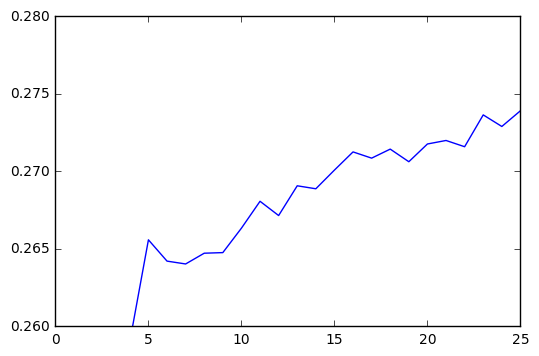

In [14]:
plt.plot(range(len(medium_selector.grid_scores_)), medium_selector.grid_scores_)
plt.ylim([0.26,0.28])

Ooooh, back up a little bit

In [6]:
start_again_mask= light_selector.ranking_ < 3

In [7]:
X_train= np.load(open('full_train_matrix_wp007.bin','rb'))
n= np.shape(X_train)[0]
X_train= X_train[0:n/2,:]
y_train= np.load(open('full_train_labels_wp007.bin','rb'))
y_train= y_train[0:n/2]

In [8]:
X_train= X_train[ :, np.where(start_again_mask)[0]]

In [9]:
tc= datetime.now()
heavy_selector = sklearn.feature_selection.RFECV(gbm, 
                                           step= 2, 
                                           cv= 3,
                                           scoring= scoring_function,
                                           verbose=1
                                          )
heavy_selector.fit(X_train, y_train)
print 'RFE took: ',(datetime.now() - tc).total_seconds(),' seconds'

Fitting estimator with 348 features.
Fitting estimator with 346 features.
Fitting estimator with 344 features.
Fitting estimator with 342 features.
Fitting estimator with 340 features.
Fitting estimator with 338 features.
Fitting estimator with 336 features.
Fitting estimator with 334 features.
Fitting estimator with 332 features.
Fitting estimator with 330 features.
Fitting estimator with 328 features.
Fitting estimator with 326 features.
Fitting estimator with 324 features.
Fitting estimator with 322 features.
Fitting estimator with 320 features.
Fitting estimator with 318 features.
Fitting estimator with 316 features.
Fitting estimator with 314 features.
Fitting estimator with 312 features.
Fitting estimator with 310 features.
Fitting estimator with 308 features.
Fitting estimator with 306 features.
Fitting estimator with 304 features.
Fitting estimator with 302 features.
Fitting estimator with 300 features.
Fitting estimator with 298 features.
Fitting estimator with 296 features.
F

In [10]:
pkl.dump(heavy_selector,open('selector_heavy.pkl','wb'))

(0.26, 0.28)

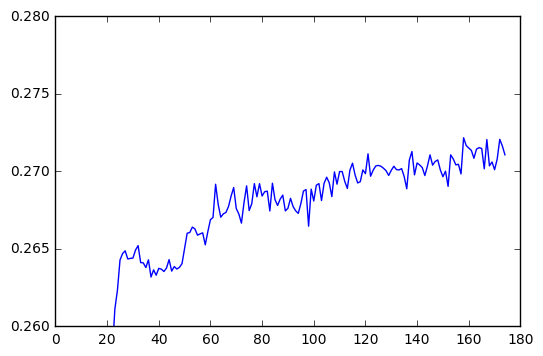

In [11]:
plt.plot(range(len(heavy_selector.grid_scores_)), heavy_selector.grid_scores_)
plt.ylim([0.26,0.28])

Prep output mask

In [5]:
heavy_selector= pkl.load(open('selector_heavy.pkl','rb'))

(0.26, 0.28)

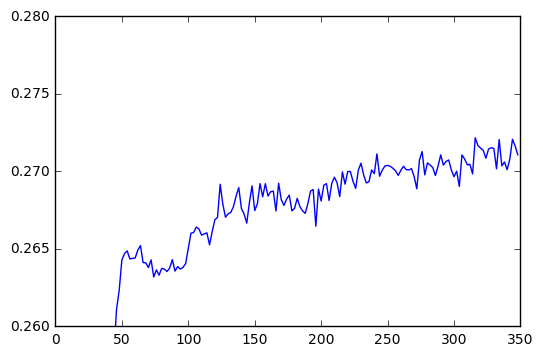

In [8]:
plt.plot(np.array(range(len(heavy_selector.grid_scores_)))*2., heavy_selector.grid_scores_)
plt.ylim([0.26,0.28])

In [9]:
medium_selector= pkl.load(open('selector_medium.pkl','rb'))

(0.26, 0.28)

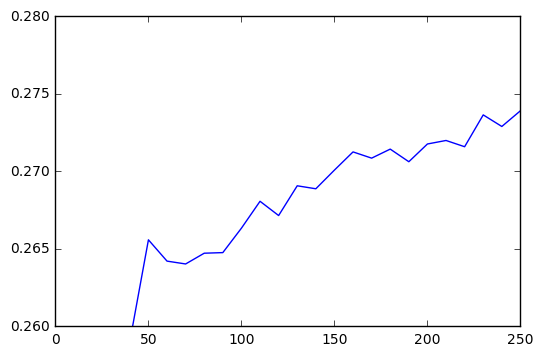

In [11]:
plt.plot(np.array(range(len(medium_selector.grid_scores_)))*10., medium_selector.grid_scores_)
plt.ylim([0.26,0.28])

In [14]:
light_selector= pkl.load(open('selector_light.pkl','rb'))

/Users/davidsutton/anaconda/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/davidsutton/anaconda/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator RFECV from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


(0.26, 0.28)

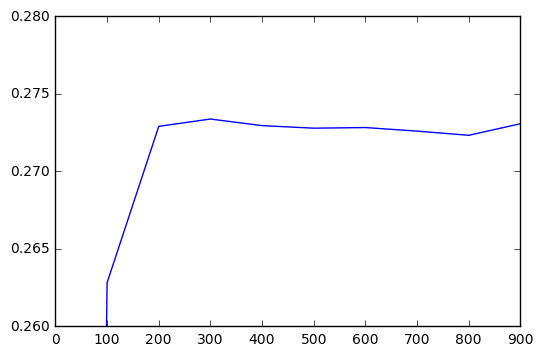

In [15]:
plt.plot(np.array(range(len(light_selector.grid_scores_)))*100., light_selector.grid_scores_)
plt.ylim([0.26,0.28])

(5.0, 800.0)

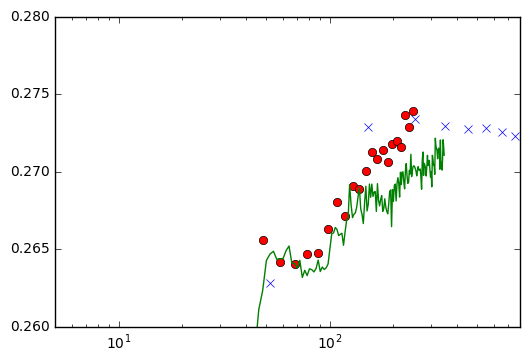

In [24]:
plt.semilogx(np.array(range(len(light_selector.grid_scores_)))*100. - 48., light_selector.grid_scores_,'bx')
plt.semilogx(np.array(range(len(medium_selector.grid_scores_)))*10.-2., medium_selector.grid_scores_,'ro')
plt.semilogx(np.array(range(len(heavy_selector.grid_scores_)))*2., heavy_selector.grid_scores_,'g-')
plt.ylim([0.26,0.28])
plt.xlim([5.,800.])

248 seems pretty good, though its unsettling that the heavy selector is discrepant at 150+ features...

In [25]:
X_train= np.load(open('full_train_matrix_wp007.bin','rb'))

In [36]:
column_mask= np.where(light_selector.support_)[0]

In [38]:
column_mask

array([  0,   1,   3,   6,   9,  10,  11,  21,  26,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134, 135,
       136, 137, 139, 142, 144, 147, 148, 149, 152, 155, 158, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
       177, 179, 181, 182, 183, 185, 186, 188, 190, 191, 193, 194, 197,
       198, 199, 200, 205, 206, 208, 210, 214, 216, 219, 220, 222, 223,
       224, 226, 229, 230, 231, 234, 237, 239, 240, 241, 242, 244, 245,
       249, 250, 251, 253, 256, 258, 259, 262, 263, 267, 270, 272, 273,
       275, 279, 280, 281, 282, 283, 284, 285, 288, 290, 291, 29

In [41]:
with open('full_248_train.csv','wb') as fout:
    # print header
    fout.write(','.join(['x_'+str(i) for i in column_mask]) + '\n')
    #
    # print each line
    for i in range(np.shape(X_train)[0]):
        fout.write(','.join([str(x) for x in X_train[i,column_mask]]) + '\n')

Have ANOTHER go

In [5]:
import sklearn.cross_validation
X_train= np.load(open('full_train_matrix_wp007.bin','rb'))
n= np.shape(X_train)[0]
# X_train= X_train[0:n/2,:]
y_train= np.load(open('full_train_labels_wp007.bin','rb'))
# y_train= y_train[0:n/2]

train,test= sklearn.cross_validation.train_test_split(range(n),test_size= 0.33,random_state=0)

X_test= X_train[test,:]
X_train= X_train[train,:]
y_test= y_train[test]
y_train= y_train[train]

/Users/davidsutton/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
import random

0.10903400480790659

In [9]:
downsample= np.array(filter(lambda x: True if ( y_train[x]==1 or random.random() < 0.5 ) else False,
                            range(np.shape(X_train)[0])
                           )
                    )

In [14]:
y_train= y_train[downsample]
X_train= X_train[downsample,:]

In [ ]:
# # Read in wp007 feature set and split into train and test
# import sklearn.cross_validation
# df= pd.read_csv('../data/train.csv',usecols= ['id','target'])
# train,test= sklearn.cross_validation.train_test_split(range(df['target'].count()),test_size= 0.33,random_state=0)
# y_train= df.target.values[train]
# y_test= df.target.values[test]
# df2= pd.read_csv('../wp007/full_248_train.csv')
# X_train= df2.as_matrix()[train,:]
# X_test= df2.as_matrix()[test,:]

In [15]:
import copy
import sklearn.metrics

In [16]:
step_size=5
num_feat= np.shape(X_train)[1]
num_steps= num_feat/step_size

last_step_seen= np.zeros(num_feat,dtype=np.int32)+num_steps
step_results= []
indices= np.array(range(num_feat))
i=0 
remainers= num_feat
while remainers > 50:
    tc= datetime.now()
    j= num_steps-i*step_size
    gbm = lightgbm.sklearn.LGBMClassifier(**lgb_params)
    gbm.fit(X_train,y_train)
    #
    pred= gbm.predict_proba(X_test)[:,1]
    print j,2.*sklearn.metrics.roc_auc_score(y_test,pred)-1.0, (datetime.now() - tc).total_seconds()
    #
    feature_importance= gbm.feature_importances_
    for k in range(step_size):
        minimal= np.min(feature_importance)
        worstFeatures= np.where(feature_importance == minimal)[0]
        toUse= np.ones(len(feature_importance),dtype=bool)
        for kk in worstFeatures:
            last_step_seen[indices[kk]]=i
            toUse[kk]= False
            remainers -= 1
        indices= indices[np.where(toUse)[0]]
        feature_importance= feature_importance[np.where(toUse)[0]]
        X_train= X_train[:,np.where(toUse)[0]]
        X_test= X_test[:,np.where(toUse)[0]]
    step_results.append( (j,2.*sklearn.metrics.roc_auc_score(y_test,pred)-1.0,np.shape(X_train)[1]) )
    i+=1

169 0.276748856907 226.158101
164 0.276196281972 204.463103
159 0.275637893099 215.226156
154 0.275808812777 206.345062
149 0.275984068047 191.550327
144 0.275700862335 182.908114
139 0.27489501523 183.456478
134 0.274976627065 179.224701
129 0.276120774995 180.184777
124 0.275498458039 176.616991
119 0.275928285711 174.008393
114 0.27539012762 168.879329
109 0.274820397339 165.142153
104 0.2765437809 159.330913
99 0.275388696771 153.85176
94 0.274774823903 150.341483
89 0.275308992241 146.500703
84 0.275647162449 146.047195
79 0.277186021391 141.414686
74 0.276149181209 139.501213
69 0.275680726547 138.320296
64 0.275536320622 134.23608
59 0.276333104693 134.076489
54 0.275829252843 123.158386
49 0.275556309466 124.090065
44 0.275440256321 115.766906
39 0.276490916665 112.715143
34 0.276434530226 109.129978
29 0.275509538214 107.033116
24 0.2767082766 103.434098
19 0.277066741414 99.792231
14 0.276281234928 96.906336
9 0.275540393496 94.605393
4 0.276820423112 91.144183
-1 0.277333318

In [18]:
import pickle as pkl
pkl.dump(last_step_seen,open('last_step_seen.pkl','wb'))

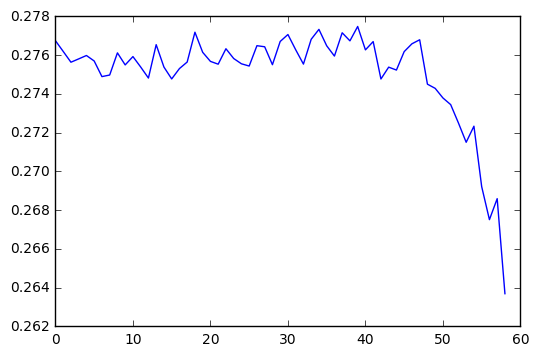

In [26]:
plt.plot( (num_steps - np.array(map(lambda x: x[0],step_results)))/step_size, map(lambda x: x[1], step_results) )

In [ ]:
# if 1==1:
#     feature_importance= gbm.feature_importances_
#     for k in range(step_size):
#         minimal= np.min(feature_importance)
#         worstFeatures= np.where(feature_importance == minimal)[0]
#         print worstFeatures
#         toUse= np.ones(len(feature_importance),dtype=bool)
#         for kk in worstFeatures:
#             last_step_seen[indices[kk]]=i
#             toUse[kk]= False
#         indices= indices[np.where(toUse)[0]]
#         feature_importance= feature_importance[np.where(toUse)[0]]
#         X_train= X_train[:,np.where(toUse)[0]]
#         X_test= X_test[:,np.where(toUse)[0]]
#     step_results.append( (j,2.*sklearn.metrics.roc_auc_score(y_test,pred)-1.0,np.shape(X_train)[1]) )

In [21]:
last_step_seen

array([ 18,  55,   0, 169,  12,   8,  48,  15,  43, 169, 169, 169,  17,
        18,   8,   4,   4,  10,  15,  15,   7,  16,  15,   0,   4,  13,
        27,   0,  42, 169,  38,  14,  27,  28, 169,  36,  32,  54,  36,
        46,  53,  48,  21,  56,  14,  56,  44,  48,  22,  26,  22,   0,
       169,  35,  39,  49, 169, 169, 169, 169,  55,  27,  52,  57,  33,
        50, 169,  43,  41,  32,  47,  44,  42,  52,  38,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,
         0,   0,   0,   0,   0,   7,   0,  32,  58,  35, 169,  53,  32,
       169,  55,  24,  42,  43,  58,  20,  35,  46, 169,  49,  31,  43,
        42,  36,  35,  50,  36,  41,  55, 169,  24, 169, 169,  43,  51,
        48,  25,  52,  44,  50, 169,  40,  22,  30,  57,  29,  13, 169,
        26,  57,  15,  10,  48,  47,  31,  44,  28,  22,  26,  11, 169,
        20,  15,  55,  36,  15,  33,  36, 169,  31, 169,  38, 169,  41,
        50,  50,  28,  38,  18,  25,  37,  33,  17,  26,  44,  2

In [22]:
np.shape(X_train)

(206282, 46)

In [23]:
pkl.dump(step_results,open('step_results.pkl','wb'))

In [29]:
step_results[39]

(-26, 0.27748244761491381, 159)

In [30]:
feature_mask= np.where(last_step_seen >= 39)[0]

In [32]:
pkl.dump(feature_mask,open('feature_mask.pkl','wb'))